# Deep learning Procesamiento de texto

## Let's install and import required libraries

In [1]:
!pip install nltk contractions

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 15.4 MB/s eta 0:00:00


In [83]:
# Data Analysis
import numpy as np
import pandas as pd

# Text preprocessing
import contractions
import matplotlib.pyplot as plt
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import seaborn as sns




# Tokenizer
import sentencepiece as spm

# Data Loading
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, TensorDataset
from tqdm.auto import tqdm

# Utils
import os
import sys
from sklearn.model_selection import train_test_split

# from torchsummary import summary
from tqdm.notebook import tqdm  # Display progress bar

## Configurations

In [3]:
# Set seed for random generators
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)

In [4]:
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
!set 'PYTORCH_CUDA_ALLOC_CONF=max_split_size_mb:2'
torch.cuda.empty_cache()
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = False

In [5]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [6]:
#Mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Reading and understanding the data

In [7]:
data = pd.read_csv("/content/drive/MyDrive/Deep Learning/Semana 4/Challenge/spam_enron1.csv", low_memory=False)

In [8]:
data.shape

(5171, 4)

In [9]:
data.head()

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


In [10]:
#Let's remove column not required columns
if 'Unnamed: 0' in data.columns:
  data.drop(columns=['Unnamed: 0'],inplace=True)

if 'label' in data.columns:
  data.drop(columns=['label'],inplace=True)

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5171 entries, 0 to 5170
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       5171 non-null   object
 1   label_num  5171 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 80.9+ KB


In [12]:
data.label_num.value_counts()

label_num
0    3672
1    1499
Name: count, dtype: int64

In [13]:
# Drop Duplicates
data.drop_duplicates(subset=["text"], inplace=True)
data = data.dropna()

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4993 entries, 0 to 5170
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       4993 non-null   object
 1   label_num  4993 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 117.0+ KB


## Text pre-processing

In [17]:
stop_words = set(stopwords.words("english"))

In [18]:
def text_cleaner(text):
    """
    Clean text column in the dataset.
    """
    # Remove quotes
    new_string = re.sub(r'"', "", text)
    # Expand contractions using the dictionary
    new_string = contractions.fix(new_string)
    #Remove Subject:
    new_string = re.sub(r"Subject: ", "", new_string)
    # Remove possessive 's
    new_string = re.sub(r"'s\b", "", new_string)
    #Remove numbers
    new_string = re.sub(r"[^a-zA-Z\s]","", new_string)
    # Lowercase words
    new_string = new_string.lower()
    # Remove non-alphabetic characters and short words, filter stop words
    tokens = [
        w
        for w in re.findall(r"\b\w+\b", new_string)
        if len(w) >= 3 and w not in stop_words
    ]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    # Join long words
    cleaned_text = " ".join(tokens).strip()

    return cleaned_text

In [19]:
data['text']=data['text'].apply(text_cleaner)

In [20]:
data['text'].head()

0    enron methanol meter follow note gave monday p...
1    hpl nom january see attached file hplnol xl hp...
2    neon retreat around wonderful time year neon l...
3    photoshop window office cheap main trending ab...
4    indian spring deal book teco pvr revenue under...
Name: text, dtype: object

## Sequence distribution

In [21]:
review_words = data["text"].apply(lambda x: len(str(x).split()))

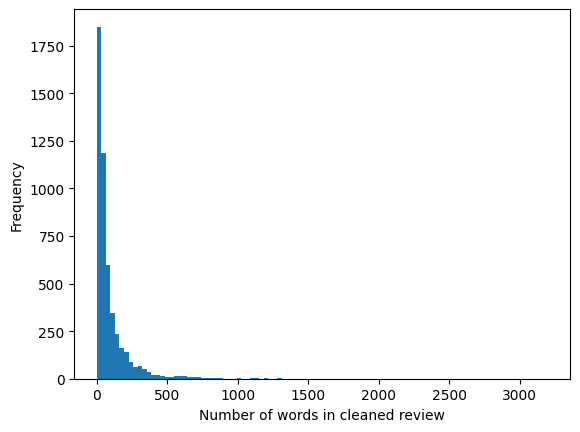

In [22]:
review_words.plot.hist(bins=100)
plt.xlabel("Number of words in cleaned review")
plt.show()

In [23]:
review_words.describe()

count    4993.000000
mean       92.464450
std       143.736549
min         0.000000
25%        21.000000
50%        45.000000
75%       105.000000
max      3200.000000
Name: text, dtype: float64

In [24]:
p = 0.9
print(f"El {100*p:.0f}% de las reseñas tiene {review_words.quantile(p):.0f} palabras")

El 90% de las reseñas tiene 218 palabras


In [25]:
all_text = " ".join(data["text"])
rev_unique_words = set(all_text.split())
rev_unique_words = len(rev_unique_words)
print(f"La serie Reseñas tiene {rev_unique_words} palabras únicas")

La serie Reseñas tiene 42698 palabras únicas


In [26]:
max_len_text = int(review_words.quantile(p))

In [27]:
max_len_text

217

In [28]:
#Splitting data into training and validation datasets
x_train, x_test, y_train, y_test = train_test_split(data["text"], data["label_num"], test_size=0.2, random_state=42, shuffle=True)

In [29]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42)

In [30]:
print(f"Hay {len(x_train)} reseñas en el conjunto de entrenamiento, {len(x_val)} en validación y {len(x_test)} reseñas en el conjunto de prueba")

Hay 3594 reseñas en el conjunto de entrenamiento, 400 en validación y 999 reseñas en el conjunto de prueba


## Tokenization

In [31]:
#Saving training dataset
x_train.to_csv("/content/drive/MyDrive/Deep Learning/Semana 4/Challenge/x_train.csv", index=False, header=False)

In [32]:
spm_rev_train = spm.SentencePieceTrainer.Train(
    input="/content/drive/MyDrive/Deep Learning/Semana 4/Challenge/x_train.csv",
    model_prefix="/content/drive/MyDrive/Deep Learning/Semana 4/Challenge/x_train",
    model_type="word",
    max_sentence_length=15000,
    vocab_size=32985,
)

In [33]:
sp_rev = spm.SentencePieceProcessor(model_file="/content/drive/MyDrive/Deep Learning/Semana 4/Challenge/x_train.model")

In [34]:
# convert text sequences into integer sequences
x_train = list(sp_rev.encode(x_train.to_list()))
x_val = list(sp_rev.encode(x_val.to_list()))
x_test = list(sp_rev.encode(x_test.to_list()))

In [35]:
y_train = y_train.to_list()
y_val = y_val.to_list()
y_test = y_test.to_list()

## Word embedding

In [36]:
def load_glove_model(glove_file):
    """Load GloVe pre-trained word embeddings into a dictionary."""
    embedding_dict = {}
    with open(glove_file, "r", encoding="utf-8") as file:
        for line in file:
            values = line.split()
            word = values[0]
            vector = np.array(values[1:], dtype="float32")
            embedding_dict[word] = vector

    return embedding_dict

In [37]:
embedding_bag = load_glove_model("/content/drive/MyDrive/Deep Learning/Semana 4/Reviews/glove.6B.300d.txt/glove.6B.300d.txt")

In [38]:
# Initialize a list to store the words
email_voc = []

# Open the file and read its contents
with open("/content/drive/MyDrive/Deep Learning/Semana 4/Challenge/x_train.vocab", "r", encoding="utf-8") as file:
    for line in file:
        # Split each line by tab ('\t') to separate the word from the score
        parts = line.strip().split("\t")

        # Check if the line has two parts (word and score)
        if len(parts) == 2:
            word = parts[0]

            # Remove the first underscore if it exists
            if word.startswith("▁"):
                word = word[1:]

            # Append the modified word to the list
            email_voc.append(word)

In [39]:
# Diccionarios de las reseñas
word_idx_email = dict(zip(email_voc, range(len(email_voc))))
idx_word_email = {index: word for word, index in word_idx_email.items()}

In [40]:
def word_vectors(dic_vocabulary, dic_embeddings_words, embedding_dim):
    """Obtiene una matriz donde cada renglón es el 'embedding vector' de una
    palabra del vocabulario"""
    num_tokens = len(dic_vocabulary)
    embedding_matrix = np.zeros((num_tokens, embedding_dim))
    found = 0
    missing_words = []

    for word, i in dic_vocabulary.items():
        embedding_vector = dic_embeddings_words.get(word)
        if embedding_vector is not None:
            # Asigna el embedding vector directamente en la matriz
            embedding_matrix[i] = embedding_vector
            found += 1
        else:
            missing_words.append(word)

    ratio = found / num_tokens * 100
    print(
        f"{found} palabras vectorizadas, que representan {ratio:.1f}% de todas las palabras en el corpus"
    )
    return embedding_matrix, missing_words

In [41]:
embedding_matrix_email, missing_words_email = word_vectors(word_idx_email, embedding_bag, 300)
embedding_matrix_email.shape

22789 palabras vectorizadas, que representan 69.1% de todas las palabras en el corpus


(32985, 300)

In [42]:
# Initialize embeddings for the new words
new_embeddings_email = []


# Initialize embeddings for the new words and add them to the dictionary
for new_word in missing_words_email[3:]:
    # Initialize the embedding for the new word with random values (dimension: 300)
    new_embedding = np.random.rand(300)
    # Add the new word and its embedding to the list
    new_embeddings_email.append(new_embedding)

new_embeddings_rev = np.array(new_embeddings_email)


extended_embedding_matrix_review = np.concatenate(
    (embedding_matrix_email, new_embeddings_rev), axis=0
)

In [43]:
extended_embedding_matrix_review.shape

(43178, 300)

## Model for classsification

In [44]:
# Casting a LongTensor
x_train_sequences = [torch.tensor(seq, dtype=torch.long) for seq in x_train]
x_val_sequences = [torch.tensor(seq, dtype=torch.long) for seq in x_val]
x_test_sequences = [torch.tensor(seq, dtype=torch.long) for seq in x_test]
# Padding
x_train_padded = pad_sequence(x_train_sequences, padding_value=0, batch_first=True)[:, :max_len_text]
x_test_padded = pad_sequence(x_test_sequences, padding_value=0, batch_first=True)[:, :max_len_text]
x_val_padded = pad_sequence(x_val_sequences, padding_value=0, batch_first=True)[:, :max_len_text]

In [45]:
y_train_tensor=torch.tensor(y_train)
y_val_tensor=torch.tensor(y_val)
y_test_tensor=torch.tensor(y_test)

In [47]:
train_dataset = TensorDataset(x_train_padded, y_train_tensor)
val_dataset = TensorDataset(x_val_padded, y_val_tensor)
test_dataset = TensorDataset(x_test_padded, y_test_tensor)

In [79]:
# Parametros
input_vocab_size = extended_embedding_matrix_review.shape[0]
output_vocab_size = 1
EMB_DIM = 300
HID_DIM = 600
EPOCHS = 10
LR = 0.0001
BATCH_SIZE = 128
target_size = 1

In [67]:
extended_embedding_matrix_review.shape

(43178, 300)

## Alternative approach

In [68]:
def count_correct_incorrect(labels, outputs, train_running_correct):
    # As the outputs are currently logits.
    outputs = torch.sigmoid(outputs)
    running_correct = 0
    for i, label in enumerate(labels):
      #print(label)
      if label < 0.5 and outputs[i] < 0.5:
        running_correct += 1
      elif label >= 0.5 and outputs[i] >= 0.5:
        running_correct += 1
    return running_correct

In [69]:
# Training function.
def train(model, trainloader, optimizer, criterion, device):
    model.train()
    print('Training')
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    for i, d in tqdm(enumerate(trainloader), total=len(trainloader)):
        counter += 1
        inputs, labels = d['data'], d['target']
        inputs = inputs.to(device)
        labels = labels.float().to(device)
        #labels = torch.tensor(labels, dtype=torch.float32).to(device)
        optimizer.zero_grad()
        # Forward pass.
        outputs = model(inputs)
        outputs = torch.squeeze(outputs, -1)
        # Calculate the loss.
        loss = criterion(outputs, labels)
        train_running_loss += loss.item()
        running_correct = count_correct_incorrect(
            labels, outputs, train_running_correct
        )
        train_running_correct += running_correct
        # Backpropagation.
        loss.backward()
        # Update the optimizer parameters.
        optimizer.step()

    # Loss and accuracy for the complete epoch.
    epoch_loss = train_running_loss / counter
    epoch_acc = 100. * (train_running_correct / len(trainloader.dataset))
    return epoch_loss, epoch_acc
# Validation function.
def validate(model, testloader, criterion, device):
    model.eval()
    print('Validation')
    valid_running_loss = 0.0
    valid_running_correct = 0
    counter = 0

    with torch.no_grad():
        for i, d in tqdm(enumerate(testloader), total=len(testloader)):
            counter += 1
            inputs, labels = d['data'], d['target']
            inputs = inputs.to(device)
            labels = labels.float().to(device)
            #labels = torch.tensor(labels, dtype=torch.float32).to(device)
            # Forward pass.
            outputs = model(inputs)
            outputs = torch.squeeze(outputs, -1)
            # Calculate the loss.
            loss = criterion(outputs, labels)
            valid_running_loss += loss.item()
            running_correct = count_correct_incorrect(
                labels, outputs, valid_running_correct
            )
            valid_running_correct += running_correct

    # Loss and accuracy for the complete epoch.
    epoch_loss = valid_running_loss / counter
    epoch_acc = 100. * (valid_running_correct / len(testloader.dataset))
    return epoch_loss, epoch_acc

In [70]:
EMBED_DIM = 300
NUM_ENCODER_LAYERS = 3
NUM_HEADS = 4

In [71]:
class EncoderClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_layers, num_heads):
        super(EncoderClassifier, self).__init__()
        self.emb = nn.Embedding(vocab_size, embed_dim)
        self.encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            batch_first=True
        )
        self.encoder = nn.TransformerEncoder(
            encoder_layer=self.encoder_layer,
            num_layers=num_layers,
        )
        self.linear = nn.Linear(embed_dim, 1)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.emb(x)
        x = self.encoder(x)
        x = self.dropout(x)
        x = x.max(dim=1)[0]
        out = self.linear(x)
        return out

In [72]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = EncoderClassifier(
    len(extended_embedding_matrix_review)+1,
    embed_dim=EMBED_DIM,
    num_layers=NUM_ENCODER_LAYERS,
    num_heads=NUM_HEADS
).to(device)
print(model)
# Total parameters and trainable parameters.
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.\n")

EncoderClassifier(
  (emb): Embedding(43179, 300)
  (encoder_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=300, out_features=300, bias=True)
    )
    (linear1): Linear(in_features=300, out_features=2048, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=2048, out_features=300, bias=True)
    (norm1): LayerNorm((300,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((300,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=300, out_features=300, bias=True)
        )
        (linear1): Linear(in_features=300, out_features=2048, bias=True)
        (dropout): Dropout(p=

In [73]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR,)

In [74]:
class MyDataset():
    def __init__(self,data,target):
        self.data = data.detach().clone()
        self.target = target.detach().clone()

    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]

        return {'data': x, 'target': y}

    def __len__(self):
        return len(self.data)

In [76]:
train_dataset=MyDataset(train_dataset.tensors[0],train_dataset.tensors[1])
val_dataset=MyDataset(val_dataset.tensors[0],val_dataset.tensors[1])
test_dataset=MyDataset(test_dataset.tensors[0],test_dataset.tensors[1])

AttributeError: 'MyDataset' object has no attribute 'tensors'

In [77]:
train_loader = DataLoader(train_dataset,batch_size=BATCH_SIZE, shuffle=True,num_workers=4)
val_loader=DataLoader(val_dataset,batch_size=BATCH_SIZE,shuffle=False,num_workers=4)
test_loader=DataLoader(test_dataset,batch_size=BATCH_SIZE,shuffle=False,num_workers=4)

In [80]:
# Lists to keep track of losses and accuracies.
train_loss, valid_loss = [], []
train_acc, valid_acc = [], []
least_loss = float('inf')
# Start the training.
for epoch in range(EPOCHS):
    print(f"[INFO]: Epoch {epoch+1} of {EPOCHS}")
    train_epoch_loss, train_epoch_acc = train(model, train_loader, optimizer, criterion, device)
    valid_epoch_loss, valid_epoch_acc = validate(model, val_loader,  criterion, device)
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_acc.append(train_epoch_acc)
    valid_acc.append(valid_epoch_acc)
    print(f"Training loss: {train_epoch_loss}, training acc: {train_epoch_acc}")
    print(f"Validation loss: {valid_epoch_loss}, validation acc: {valid_epoch_acc}")
    # Save model.
    if valid_epoch_loss < least_loss:
        least_loss = valid_epoch_loss
        print(f"Saving best model till now... LEAST LOSS {valid_epoch_loss:.3f}")
        torch.save(model, os.path.join(r'/content/drive/MyDrive/Deep Learning/Semana 4/Challenge', 'model.pth')
        )
    print('-'*50)

[INFO]: Epoch 1 of 10
Training


  0%|          | 0/15 [00:00<?, ?it/s]

Validation


  0%|          | 0/2 [00:00<?, ?it/s]

Training loss: 0.06724167813857397, training acc: 99.19309961046187
Validation loss: 0.10139628872275352, validation acc: 98.0
Saving best model till now... LEAST LOSS 0.101
--------------------------------------------------
[INFO]: Epoch 2 of 10
Training


  0%|          | 0/15 [00:00<?, ?it/s]

Validation


  0%|          | 0/2 [00:00<?, ?it/s]

Training loss: 0.06878711879253388, training acc: 99.08180300500835
Validation loss: 0.08631130307912827, validation acc: 97.75
Saving best model till now... LEAST LOSS 0.086
--------------------------------------------------
[INFO]: Epoch 3 of 10
Training


  0%|          | 0/15 [00:00<?, ?it/s]

Validation


  0%|          | 0/2 [00:00<?, ?it/s]

Training loss: 0.05751577441891034, training acc: 98.60879243183082
Validation loss: 0.07962522655725479, validation acc: 98.0
Saving best model till now... LEAST LOSS 0.080
--------------------------------------------------
[INFO]: Epoch 4 of 10
Training


  0%|          | 0/15 [00:00<?, ?it/s]

Validation


  0%|          | 0/2 [00:00<?, ?it/s]

Training loss: 0.045557282368342084, training acc: 99.44351697273233
Validation loss: 0.08088325336575508, validation acc: 98.5
--------------------------------------------------
[INFO]: Epoch 5 of 10
Training


  0%|          | 0/15 [00:00<?, ?it/s]

Validation


  0%|          | 0/2 [00:00<?, ?it/s]

Training loss: 0.038559615487853686, training acc: 99.55481357818586
Validation loss: 0.06571892462670803, validation acc: 98.75
Saving best model till now... LEAST LOSS 0.066
--------------------------------------------------
[INFO]: Epoch 6 of 10
Training


  0%|          | 0/15 [00:00<?, ?it/s]

Validation


  0%|          | 0/2 [00:00<?, ?it/s]

Training loss: 0.0297089039037625, training acc: 99.63828603227601
Validation loss: 0.06909548118710518, validation acc: 96.75
--------------------------------------------------
[INFO]: Epoch 7 of 10
Training


  0%|          | 0/15 [00:00<?, ?it/s]

Validation


  0%|          | 0/2 [00:00<?, ?it/s]

Training loss: 0.026889607279251018, training acc: 99.58263772954925
Validation loss: 0.056633539497852325, validation acc: 99.25
Saving best model till now... LEAST LOSS 0.057
--------------------------------------------------
[INFO]: Epoch 8 of 10
Training


  0%|          | 0/15 [00:00<?, ?it/s]

Validation


  0%|          | 0/2 [00:00<?, ?it/s]

Training loss: 0.020670812266568344, training acc: 99.72175848636617
Validation loss: 0.05517826788127422, validation acc: 99.0
Saving best model till now... LEAST LOSS 0.055
--------------------------------------------------
[INFO]: Epoch 9 of 10
Training


  0%|          | 0/15 [00:00<?, ?it/s]

Validation


  0%|          | 0/2 [00:00<?, ?it/s]

Training loss: 0.015373020844223598, training acc: 99.86087924318309
Validation loss: 0.05132043547928333, validation acc: 99.0
Saving best model till now... LEAST LOSS 0.051
--------------------------------------------------
[INFO]: Epoch 10 of 10
Training


  0%|          | 0/15 [00:00<?, ?it/s]

Validation


  0%|          | 0/2 [00:00<?, ?it/s]

Training loss: 0.013330951767663161, training acc: 99.91652754590984
Validation loss: 0.05073028616607189, validation acc: 99.0
Saving best model till now... LEAST LOSS 0.051
--------------------------------------------------


In [81]:
train_acc

[99.19309961046187,
 99.08180300500835,
 98.60879243183082,
 99.44351697273233,
 99.55481357818586,
 99.63828603227601,
 99.58263772954925,
 99.72175848636617,
 99.86087924318309,
 99.91652754590984]

In [82]:
plt.title("Line Graph")
plt.xlabel("X Axis")
plt.ylabel("Y Axis")

plt.plot(a[0], b[0], color="red")  # note a[0] instead of a
plt.show()

[98.0, 97.75, 98.0, 98.5, 98.75, 96.75, 99.25, 99.0, 99.0, 99.0]

In [ ]:
sns.lineplot